In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
from CleaningFunctions import Clean


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Read in data as pandas dataframe

df=pd.read_csv("2016_2019_USmovies.csv")
df.head()


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,title,check,averageRating,numVotes,budget_LCY,gross_USA_USD,cumm_worldwide_gross_USD
0,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,\N,122,Drama,The Other Side of the Wind,1,6.9,4989,NaN,NaN,NaN
1,tt0339736,movie,The Evil Within,The Evil Within,0,2017,\N,98,Horror,The Evil Within,1,5.5,2572,$6000000,NaN,NaN
2,tt0360556,movie,Fahrenheit 451,Fahrenheit 451,0,2018,\N,100,"Drama,Sci-Fi,Thriller",Fahrenheit 451,1,4.9,15295,NaN,NaN,NaN
3,tt0365545,movie,Nappily Ever After,Nappily Ever After,0,2018,\N,98,"Comedy,Drama,Romance",Nappily Ever After,1,6.4,6718,NaN,NaN,NaN
4,tt0369610,movie,Jurassic World,Jurassic World,0,2015,\N,124,"Action,Adventure,Sci-Fi",Jurassic World,1,7.0,549806,$150000000,652.27,1670.4


In [4]:
# Let's clean the data and rename columns so we know what we're looking at

columns=["tconst","title","isAdult","startYear","runtimeMinutes","check","averageRating","genres","numVotes"]
names=["Title_ID","Title","Adult","Release_Year","Runtime(Minutes)","Check","Rating","Genre","Number_of_Votes"]

for column,name in list(zip(columns,names)):
    df.rename(columns={column:name},inplace=True)
    
df.head()

,Title_ID,titleType,primaryTitle,originalTitle,Adult,Release_Year,endYear,Runtime(Minutes),Genre,Title,Check,Rating,Number_of_Votes,budget_LCY,gross_USA_USD,cumm_worldwide_gross_USD
0,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,\N,122,Drama,The Other Side of the Wind,1,6.9,4989,NaN,NaN,NaN
1,tt0339736,movie,The Evil Within,The Evil Within,0,2017,\N,98,Horror,The Evil Within,1,5.5,2572,$6000000,NaN,NaN
2,tt0360556,movie,Fahrenheit 451,Fahrenheit 451,0,2018,\N,100,"Drama,Sci-Fi,Thriller",Fahrenheit 451,1,4.9,15295,NaN,NaN,NaN
3,tt0365545,movie,Nappily Ever After,Nappily Ever After,0,2018,\N,98,"Comedy,Drama,Romance",Nappily Ever After,1,6.4,6718,NaN,NaN,NaN
4,tt0369610,movie,Jurassic World,Jurassic World,0,2015,\N,124,"Action,Adventure,Sci-Fi",Jurassic World,1,7.0,549806,$150000000,652.27,1670.4


In [5]:
# Now to drop columns we aren't interested in or that hold irrelevant data

df.drop(columns=["titleType","primaryTitle","originalTitle","endYear","Adult","Check"],inplace=True)

df.head()

,Title_ID,Release_Year,Runtime(Minutes),Genre,Title,Rating,Number_of_Votes,budget_LCY,gross_USA_USD,cumm_worldwide_gross_USD
0,tt0069049,2018,122,Drama,The Other Side of the Wind,6.9,4989,NaN,NaN,NaN
1,tt0339736,2017,98,Horror,The Evil Within,5.5,2572,$6000000,NaN,NaN
2,tt0360556,2018,100,"Drama,Sci-Fi,Thriller",Fahrenheit 451,4.9,15295,NaN,NaN,NaN
3,tt0365545,2018,98,"Comedy,Drama,Romance",Nappily Ever After,6.4,6718,NaN,NaN,NaN
4,tt0369610,2015,124,"Action,Adventure,Sci-Fi",Jurassic World,7.0,549806,$150000000,652.27,1670.4


In [6]:
# Create binaries for the genres we're interested in for analysis later on

In [7]:
# Now to check our data makes sense and we have no nulls
print(df.describe())
print(df.info())
print(df.shape)

       Release_Year  Runtime(Minutes)       Rating  Number_of_Votes  \
count   2015.000000       2015.000000  2015.000000      2015.000000   
mean    2016.715633        101.181141     5.920447     42005.702233   
std        1.355422         15.783114     1.051272     91376.330598   
min     2014.000000         46.000000     1.400000       984.000000   
25%     2016.000000         90.000000     5.300000      2377.500000   
50%     2017.000000         98.000000     6.000000      7601.000000   
75%     2018.000000        109.000000     6.600000     36685.500000   
max     2019.000000        209.000000    10.000000    844981.000000   

       gross_USA_USD  cumm_worldwide_gross_USD  
count    1085.000000               1386.000000  
mean       46.304341                 91.579856  
std        91.560188                225.040751  
min         0.000000                  0.000000  
25%         0.650000                  0.260000  
50%        11.960000                  7.230000  
75%        49.950

In [8]:
# Now split into separate databases based on genre

df_comedy=df.loc[df["Genre"]=="Comedy",:]
df_drama=df.loc[df["Genre"]=="Drama",:]
df_horror=df.loc[df["Genre"]=="Horror",:]
df_scifi=df.loc[df["Genre"]=="Sci-Fi",:]
df_action=df.loc[df["Genre"]=="Action",:]
df_romance=df.loc[df["Genre"]=="Romance",:]


# Print shape of dataframe so we know the sample sizes

print("df_comedy contains",df_comedy.shape,"entries")
print("df_drama contains",df_drama.shape,"entries")
print("df_horror contains",df_horror.shape,"entries")
print("df_scifi contains",df_scifi.shape,"entries")
print("df_action contains",df_action.shape,"entries")
print("df_romance contains",df_romance.shape,"entries")


df_comedy contains (101, 10) entries
df_drama contains (112, 10) entries
df_horror contains (64, 10) entries
df_scifi contains (4, 10) entries
df_action contains (7, 10) entries
df_romance contains (3, 10) entries


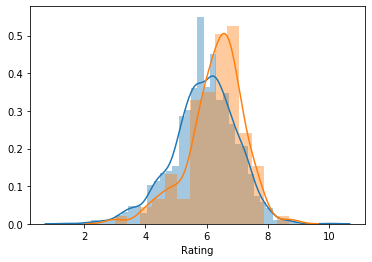

In [9]:
sns.distplot(df.Rating)
sns.distplot(df_drama.Rating)
# sns.distplot(df_horror.Rating)
# sns.distplot(df_scifi.Rating)
# sns.distplot(df_action.Rating)
# sns.distplot(df_romance.Rating)

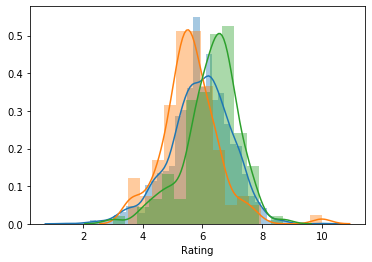

In [10]:
sns.distplot(df.Rating)
sns.distplot(df_comedy.Rating)
sns.distplot(df_drama.Rating)

In [11]:
print("For the population the standard deviation is:",df.Rating.std()," with a median value of:",df.Rating.median()," and a mean value of:",df.Rating.mean())

print("For Comedy the standard deviation is:",df_comedy.Rating.std()," with a median value of:",df_comedy.Rating.median()," and a mean value of:",df_comedy.Rating.mean())

print("For Drama the standard deviation is:",df_drama.Rating.std()," with a median value of:",df_drama.Rating.median()," and a mean value of:",df_drama.Rating.mean())


For the population the standard deviation is: 1.051271891981967  with a median value of: 6.0  and a mean value of: 5.92044665012407
For Comedy the standard deviation is: 0.9587884268829868  with a median value of: 5.6  and a mean value of: 5.595049504950495
For Drama the standard deviation is: 0.9169218376561092  with a median value of: 6.4  and a mean value of: 6.291964285714286
